# PHYS20762 - Project  2 - Numerical Integration
student ID: 10485506 <br>
University of Manchester <br>
April 2021

We first initialise Python interpreter.

In [82]:
# Initialisation
import numpy as np
import matplotlib.pyplot as plt
# to work with complex numbers
import cmath

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Project Outline 

The aim of this project is to investigate how different numerical integration methods apply to a physical systems of forced harmonic oscillator. The equation of motion is $mx’’(t)+bx’(t)+kx(t) = F(t)$, where x is position and it's corresponding derivatives, F is the external force on the system, m is mass and k, b are spring and damping constants respectively.

This differential equation can be solved analytically for specific functional forms $F(t)$, but not for all. The investigation will start considering a specific case of $F(t) = 0$ to pick the best numerical integration method as the analytical solution is known. It will carry on with looking at some other forms of external force function. 

Four different integration techniques are tested:<br>
(1) Euler <br>
(2) Improved Euler <br>
(3) Verlet <br>
(4) Euler-Cromer <br>

In [83]:
# definne constants, Fixed for this system
k = 3.34 # kg*s^-2
m = 4.62 # kg

## Analytic Solution

First, we solve the differential equation analytically to be able to compare to our approximated solutions given by numerical integration. The analytical solution is an exponentially decaying oscillation about the equilibrium position (x = 0 in this case). The rate of decay is specified by b.

$x(t) = e^{\frac{-\gamma t}{2}}(Ae^{i\omega t} + Be^{-i\omega t})$, where $\gamma = \frac{b}{m}$ and $\omega^2 = {\omega_0}^2 - \frac{\gamma^2}{4}$.<br> $\omega_0 = \sqrt{\frac{k}{m}}$ is the natural frequency of the system (frequency it would oscillate at without any external force influence.

In [84]:
# The analytic solution (when damping constant b is less than critical b_cr)
def Analytic(b, time, x0=0, v0=-1, velocity=False):
    """
    Alalytical model of a damped harmonic oscillator.
    
    Parameters
    ----------
    b - damping constant (float)
    time - time of the oscillations (float array)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    velocity - optional return (bool)
    
    Return
    ----------
    X - position for each time (float array)
    V (optional) - velocity for each time (float array)
    """

    # Constants
    A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x0+v0*m/(cmath.sqrt(4*k*m-b**2)*1j) 
    B = x0-A
    
    # position, given by solving the original differential equation
    X = np.exp(-b*time/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m - b**2)*time/(2*m))
                              +B*np.exp(-1j*cmath.sqrt(4*k*m - b**2)*time/(2*m)))
    
    # velocity (optional output) - usefull for energy calculations. Derivative of the position.
    if velocity == True:
        V = (-b/(2*m)*np.exp(-b*time/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m - b**2)*time/(2*m))
                                  + B*np.exp(-1j*cmath.sqrt(4*k*m - b**2)*time/(2*m)))
             + np.exp(-b*time/(2*m))*(A*(1j*cmath.sqrt(4*k*m - b**2)/(2*m))
                                     *np.exp(1j*cmath.sqrt(4*k*m - b**2)*time/(2*m))
                                  + B*(-1j*cmath.sqrt(4*k*m - b**2)/(2*m))
                                     *np.exp(-1j*cmath.sqrt(4*k*m - b**2)*time/(2*m))))
        return X, V
    
    else:
        return X

Plot to see if we get what is expected from the system for different values of b.

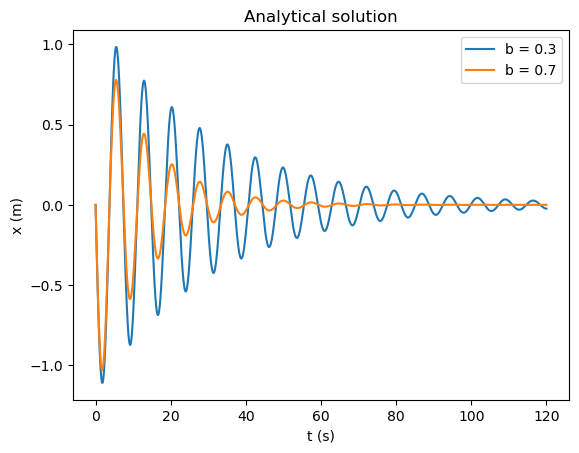

In [85]:
# Time range for our observation
T = np.arange(0, 120.01, 0.01)

# Choose different different damping constants (b < b_cr)
b_1 = 0.3 # kg/s
b_2 = 0.7 # kg/s

# plotting analytical solution for underdamping
plt.plot(T, Analytic(b_1, T).real, label='b = {}'.format(b_1))
plt.plot(T, Analytic(b_2, T).real, label='b = {}'.format(b_2))

# formating plot 
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.title('Analytical solution')
plt.legend()
plt.show()

# Integrating models

### Euler Method

This method is derived using first two terms in Taylor series for position x and velocity v about some point in time t.

e. g. for position, at time t+h, where h is a small increment in time, Taylor expansion is $x(t + h) = x(t) + hx'(t)$ where $x'(t)$ is the first derivative of the position, which is velocity of the system as well. So we can form iterative formula as follows: <br>
$x_{i+1} = x_{i} + h v_{i}$ <br>

Similarly, for velocity: <br>
$v_{i+1} = v_{i} + h a_{i}$  <br>

Acceleration is given by the Newton's law $ma = -kx - bv$, so<br>
$a_{i} = \frac{k}{m} x_{i} -\frac{b}{m} v_{i}$

In [86]:
def EulerMethod(b, nsteps, hstep, x0=0, v0=-1):
    """
    An itterative method for modeling damped harmonic oscillator.
    
    Parameters
    ----------
    b - damping constant (float)
    nsteps - number of steps for the itteration (int)
    hstep - the size of one step (float)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    
    Return
    ----------
    x - position for each step (float array)
    v - velocity for each step (float array)
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    
    # Fill in the position and velocity arrays
    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        # Notice we don't make an array of these, as we usually don't need to remember them all
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*hstep
        v[i+1] = v[i] + a*hstep
        
    return x, v

Now create a plot to compare how accurate results given by this approximation are.

In [87]:
# Create a plotting function as it will be used several times

def AnalyticCompare(b, hstep, time, model, model_name, plot_name, colour='blue'):
    """
    Plots modeled solution against analytic.
    
    Parameters
    ----------
    x0 - initial position (float)
    v0 - initial velocity (float)
    b - damping constant (float)
    hstep - the size of one step (float)
    time - time of the oscillations (float array)
    model (function)
    model name (string)
    colour (string)
    
    Return
    ----------
    None
    """
    # Plot analytic solution
    plt.plot(time, Analytic(b, time).real, linewidth=3, color=colour, label='analytic solution')
    
    nsteps = int(time[-1]/hstep)
    
    # call the iterative method 
    x, v = model(b, nsteps, hstep)
    # plot the outcome by displaying the position only 
    plt.plot(np.arange(0, time[-1], hstep), x, 'k--', label=model_name)

    # labeling plot 
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.title(plot_name)
    plt.legend()
    plt.show()

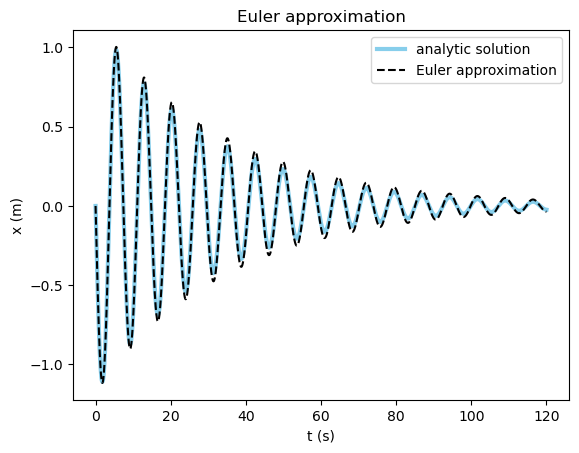

In [88]:
AnalyticCompare(b_1, 0.01, T, EulerMethod, 'Euler approximation', 'Euler approximation', 'skyblue')

### Improved Euler Method

Similar to Euler method, but in one further term in the Taylor expansion of $x(t + h)$. Results in the following formulae:

$x_{i+1} = x_{i} + h v_{i} + \frac{h^{2}}{2} a_{i}$ <br>
$v_{i+1} = v_{i} + h a_{i}$  <br>

and<br>
$a_{i} = \frac{k}{m} x_{i} -\frac{b}{m} v_{i}$ as before

In [89]:
def ImprovedEulerMethod(b, nsteps, hstep, x0=0, v0=-1):
    """
    An itterative method for modeling damped harmonic oscillator.
    
    Parameters
    ----------
    b - damping constant (float)
    nsteps - number of steps for the itteration (int)
    hstep - the size of one step (float)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    
    Return
    ----------
    x - position for each step (float array)
    v - velocity for each step (float array)
    """
    
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    
    # Fill in the position and velocity arrays
    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        # Notice we don't make an array of these, as we usually don't need to remember them all
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*hstep + hstep**2 * a / 2
        v[i+1] = v[i] + a*hstep
        
    return x, v

Now create a plot to compare how accurate results given by this approximation are.

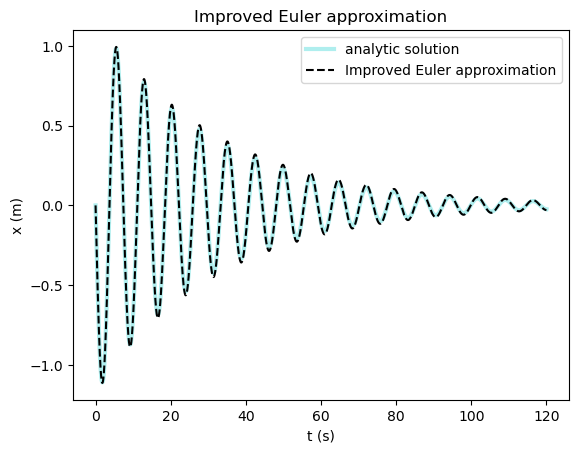

In [90]:
AnalyticCompare(b_1, 0.01, T, ImprovedEulerMethod, 'Improved Euler approximation', 'Improved Euler approximation', 'paleturquoise')

### Verlet's method

This method is based on the centred derivative:
$x^{'}(t) = \lim_{h\to0} \frac{x(t + h) - x(t-h)}{2h}$

Calculating first and second derivatives and combining them to get x gives the following:

$x_{i+1} = A x_{i} + B x_{i-1}$   Note, this method is not self starting, as it requires two consecutive values of x to calculate the trird in a sequence. <br>

where $A = 2 \frac{2m - kh^{2}}{2m + bh}$ and $B = \frac{bh - 2m}{2m + bh}$

In [91]:
def VerletMethod(b, nsteps, hstep, x0=0, v0=-1):
    """
    An itterative method for modeling damped harmonic oscillator.
    
    Parameters
    ----------
    b - damping constant (float)
    nsteps - number of steps for the itteration (int)
    hstep - the size of one step (float)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    
    Return
    ----------
    x - position for each step (float array)
    v - velocity for each step (float array)
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    
    # First step will be done using Improved Euler method, because Verlet method is not self-starting
    a = -(k/m) * x[0] - (b/m) * v[0]
    # calculate x (m) for the later step i+1
    x[1] = x[0] + v0 * hstep + hstep**2 * a / 2
    
    # velocity also will be usefull in future calculations
    v[1] = v[0] + a*hstep

    for i in range(nsteps-2):
        # Constant multipliers
        D = 2*m + b*hstep
        A = 2 * (2*m - k * hstep**2) / D
        B = (b*hstep - 2*m) / D

        # For each configuration at step i and i + 1, calculate x (in m) for the later step i+2
        x[i+2] = A*x[i+1] + B*x[i]
        v[i+2] = (x[i+2] - x[i]) / (2 * hstep)
   
    return x, v

Now create a plot to compare how accurate results given by this approximation are.

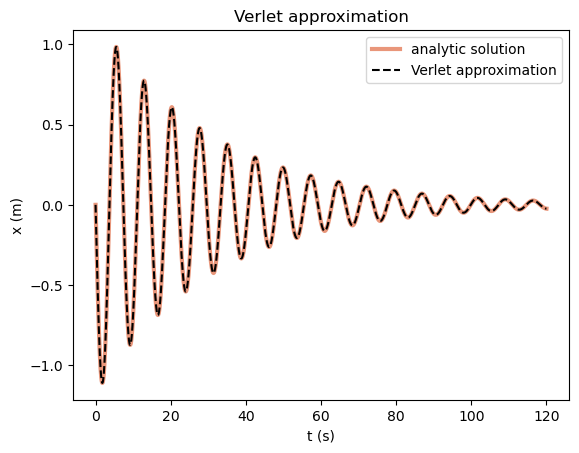

In [92]:
AnalyticCompare(b_1, 0.01, T, VerletMethod, 'Verlet approximation', 'Verlet approximation', 'darksalmon')

### Euler-Cromer method

This method uses the same relations as the Euler method, but instead of taking velocity at an earlier point $v_i$, it takes the instantaneous velocity at the point of calculation $v_{i+1}$.

Energy of the system $E_{i+1}(t) = \frac{1}{2}kx_{i+1}^2 + \frac{1}{2}mv_{i+1}^2 = E_i(1 + \frac{k}{m}h^2)$ is increasing with each step according to the Euler method with no damping, which is unphysical. The correction made fixes this, preserving the total energy of the system (averaged over one oscillation). 

$x_{i+1} = x_{i} + h v_{i+1}$ <br>
$v_{i+1} = v_{i} + h a_{i}$  <br>

and<br>
$a_{i} = \frac{k}{m} x_{i} -\frac{b}{m} v_{i}$ as before

In [93]:
def EulerCromerMethod(b, nsteps, hstep, x0=0, v0=-1):
    """
    An itterative method for modeling damped harmonic oscillator.
    
    Parameters
    ----------
    b - damping constant (float)
    nsteps - number of steps for the itteration (int)
    hstep - the size of one step (float)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    
    Return
    ----------
    x - position for each step (float array)
    v - velocity for each step (float array)
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        # Notice we don't make an array of these, as we usually don't need to remember them all
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a*hstep
        x[i+1] = x[i] + v[i+1]*hstep
        
    return (x, v)

Now create a plot to compare how accurate results given by this approximation are.

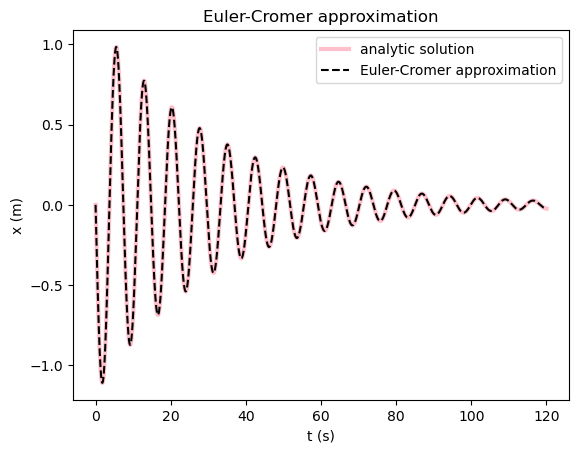

In [94]:
AnalyticCompare(b_1, 0.01, T, EulerCromerMethod, 'Euler-Cromer approximation', 'Euler-Cromer approximation', 'pink')

### Plotting all results together to compare the accuracy

First, we investigate several damping constants.

In [95]:
# Define a smaller plotting routine to simplify the final procedure

def PlotModel(model, b, hstep, end_time, model_name, colour):
    
    nsteps = int(end_time/hstep)
    
    x, v = model(b, nsteps, hstep)
    plt.plot(np.arange(0, T[-1], hstep), x, color=colour, linestyle='--', label=model_name)
    

In [96]:
# To focus on a smaller region, redefine T
T = np.arange(0, 60.01, 0.01)

# Create an array of models, which will be used
models = np.array([EulerMethod, ImprovedEulerMethod, VerletMethod, EulerCromerMethod])

# Define parameters of the plot
colours = np.array(['skyblue', 'blue', 'red', 'black'])
labels = np.array(['Euler approximation', 
                   'Improved Euler approximation', 
                   'Verlet approximation', 
                   'Euler-Cromer approximation'])

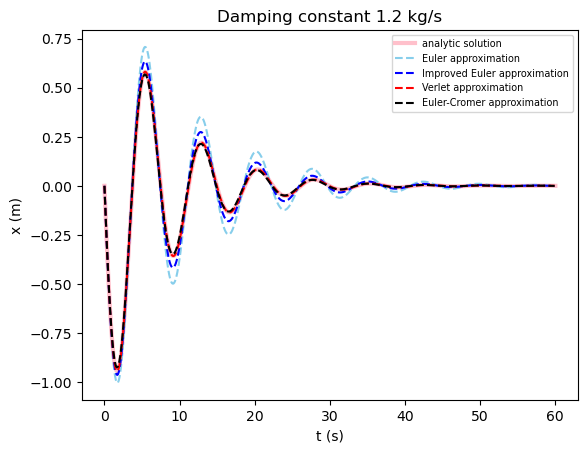

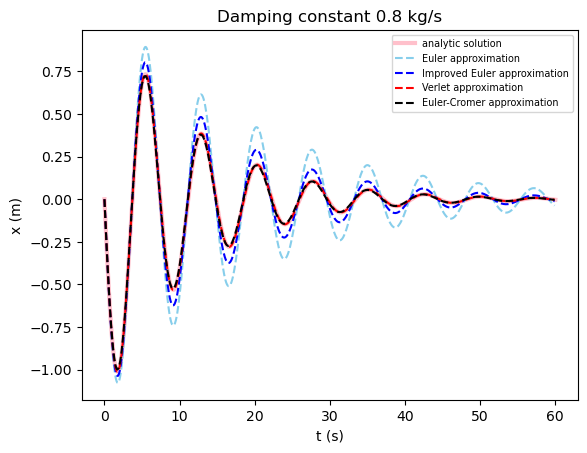

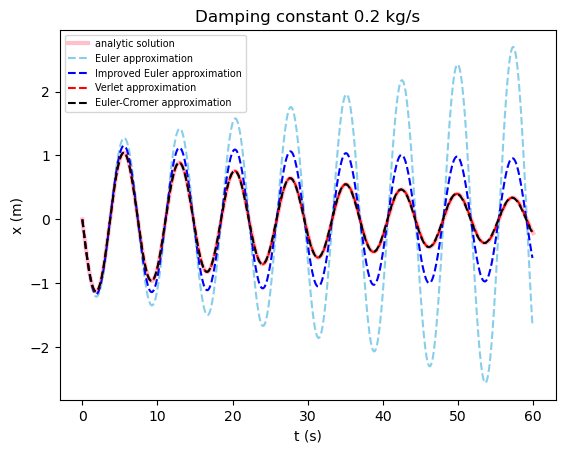

In [97]:
# Define an array of damping constants
b = np.array([1.2, 0.8, 0.2]) # kg/s

for b_i in b:
    
    # PLot analytic solution
    plt.plot(T, Analytic(b_i, T).real, linewidth=3, color='pink', label='analytic solution')
    
    # Plot approximations
    for i in range(len(models)):
        
        PlotModel(models[i], b_i, 0.1, T[-1], labels[i], colours[i])
    
    # Format the plot 
    plt.title('Damping constant {} kg/s'.format(b_i))
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.legend(fontsize='x-small')
    plt.show()

Then, we look at the further accuracy and the efficiency of each method by looking at their dependence of different step sizes for the medium value of b.

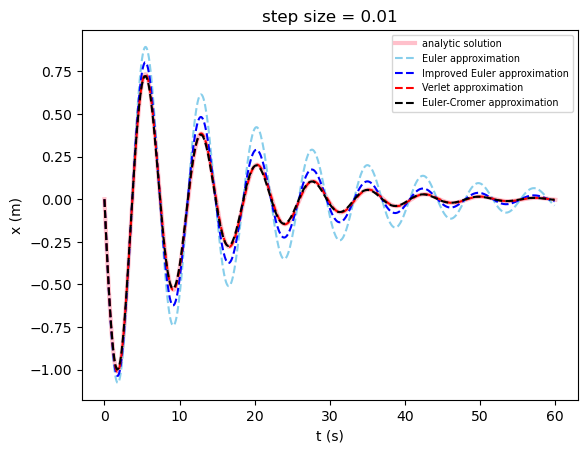

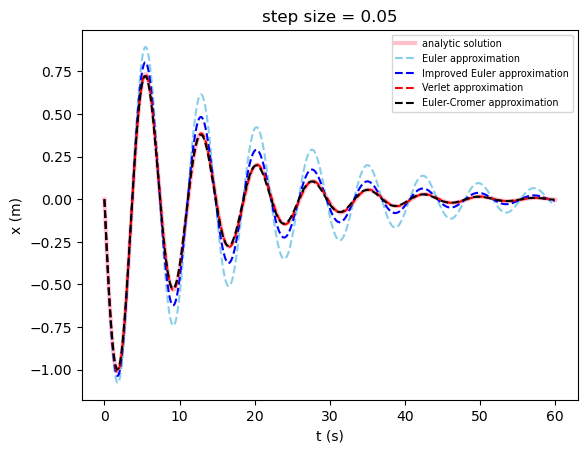

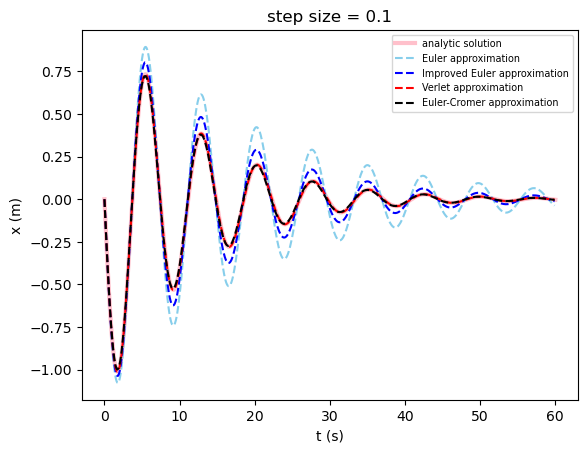

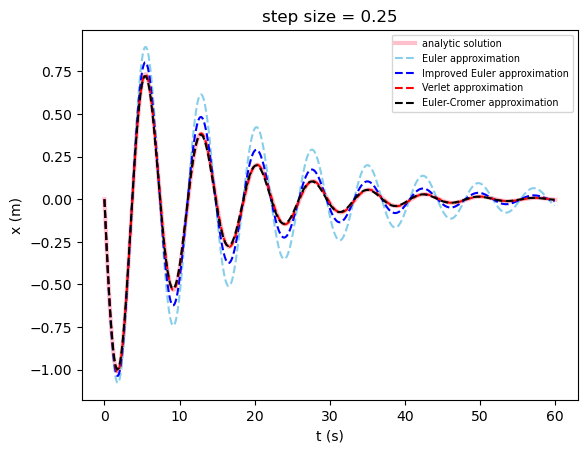

In [98]:
# Define an array of step sizes
hsteps = np.array([0.01, 0.05, 0.1, 0.25])

for hstep_i in hsteps:
    
    # Plot analytic solution
    plt.plot(T, Analytic(0.8, T).real, linewidth=3, color='pink', label='analytic solution')
    
    # Plot approximations
    for i in range(len(models)):
        
        PlotModel(models[i], 0.8, 0.1, T[-1], labels[i], colours[i])
    
    # Format the plot 
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.legend(fontsize='x-small')
    plt.title('step size = {}'.format(hstep_i))
    plt.show()

Graphically, it can be seen, that the success of performance of Euler and Improved Euler methods relies heavily on the choice of damping constant and step size. In general, they do not conserve energy for lower damping constants for this system and require more steps to give a reasonable accuracy. The other two methods, namely Verlet and Euler-Cromer approximations, tend to perform better and more independently of tested factors. 

This is justified by the fact that the truncation error in the methods have different h dependence.<br> 
Euler - $error\sim O(h^2)$ <br>
Improved Euler - $error\sim O(h^3)$ <br>
Verlet - $error\sim O(h^4)$ <br>
Euler-Cromer - $error\sim O(h^2)$ (this one is energy preserving, so it does well)<br>

Therefore, latter two will be investigated further by quantifying the error they give on the positions of the oscillating mass and on the energy of the whole system, using different values of step size h.

## Choosing the best method 

### Position error 

To investigate how well a method calculates the position during the given time interval T, the mean error on the position is calculated. 

$ \Delta x = \mid{x_i - x(t_i)}\mid $ , where $x_i$ is position given by the approximation model and $x(t_i)$ is the position at time t_i given by the analytical solution.

In [99]:
# Define an array of step sizes and b
hsteps = np.array([0.01, 0.05, 0.1, 0.25])
b = 0.8 # kg/s

for hstep in hsteps:
    
    T = np.arange(0, 60, hstep)
    nsteps = len(T)
    x_V, v_V = VerletMethod(b, nsteps, hstep)
    x_C, v_C = EulerCromerMethod(b, nsteps, hstep)
    
    verlet_error = np.abs(Analytic(b, T).real - x_V)
    cromer_error = np.abs(Analytic(b, T).real - x_C)
    
    print('For the step size {}'.format(hstep))
    print('verlet error = {}'.format(np.mean(verlet_error)))
    print('cromer error = {}'.format(np.mean(cromer_error)))
    if np.mean(verlet_error) > np.mean(cromer_error):
        print('Verlet error is greather by {:.5f}'.format(np.abs(np.mean(verlet_error)-np.mean(cromer_error))))
    elif np.mean(verlet_error) < np.mean(cromer_error):
        print('Cromer error is greather by {:.5f}'.format(np.abs(np.mean(verlet_error)-np.mean(cromer_error))))
    print('..............................................')

For the step size 0.01
verlet error = 4.664878458610267e-06
cromer error = 0.000685493808628564
Cromer error is greather by 0.00068
..............................................
For the step size 0.05
verlet error = 0.00011664958410724573
cromer error = 0.003480375741699729
Cromer error is greather by 0.00336
..............................................
For the step size 0.1
verlet error = 0.00046699180834665436
cromer error = 0.007095824151124256
Cromer error is greather by 0.00663
..............................................
For the step size 0.25
verlet error = 0.002937131682171005
cromer error = 0.018768744195841403
Cromer error is greather by 0.01583
..............................................


It can be seen that Euler-Cromer method gives bigger error in all cases, and difference in two increases with the step size.

### Energy error

We can investigate the error on one other crucial parameter - energy of the system. <br>
$E_i(t) = \frac{1}{2}kx_i^2 + \frac{1}{2}mv_i^2$, where symbols have their usual meanings. <br>
Energies are compared in a similar manner to positions.

In [100]:
# define energy function

def Energy(x, v):
    
    E = 0.5 * k * x**2 + 0.5 * m * v**2 
    
    return E

In [101]:
for hstep in hsteps:
    
    T = np.arange(0, 60, hstep)
    nsteps = len(T)
    x_V, v_V = VerletMethod(b, nsteps, hstep)
    x_C, v_C = EulerCromerMethod(b, nsteps, hstep)
    x_real, v_real = Analytic(b, T, velocity=True)
    
    
    verlet_error = np.abs(Energy(x_real.real, v_real.real) - Energy(x_V, v_V))
    cromer_error = np.abs(Energy(x_real.real, v_real.real) - Energy(x_C, v_C))
    
    print('For the step size {}'.format(hstep))
    print('verlet error = {}'.format(np.mean(verlet_error)))
    print('cromer error = {}'.format(np.mean(cromer_error)))
    if np.mean(verlet_error) > np.mean(cromer_error):
        print('Verlet error is greather by {:.5f}'.format(np.abs(np.mean(verlet_error)-np.mean(cromer_error))))
    elif np.mean(verlet_error) < np.mean(cromer_error):
        print('Cromer error is greather by {:.5f}'.format(np.abs(np.mean(verlet_error)-np.mean(cromer_error))))
    print('..............................................')

For the step size 0.01
verlet error = 0.0012734824119100924
cromer error = 0.0007327940151473065
Verlet error is greather by 0.00054
..............................................
For the step size 0.05
verlet error = 0.006346050750756964
cromer error = 0.003615445715265627
Verlet error is greather by 0.00273
..............................................
For the step size 0.1
verlet error = 0.0126377823442043
cromer error = 0.007116890870465816
Verlet error is greather by 0.00552
..............................................
For the step size 0.25
verlet error = 0.03136446368378724
cromer error = 0.017001255121750304
Verlet error is greather by 0.01436
..............................................


Now the opposite can be seen. Euler-Cromer method is doing better, because it is specifically designed to be energy preserving. Therefore, the choice of the right method would depend of what quantities one is interested in. Here, the compromise between the two it terms of required.

## Accuracy calibration  

Let us say the desired accuracy in position has to be to the nearest millimetre as the real measurement would hardly ever do better than this. So the error on position measurement would have to be less that 0.0005 meters. <br>
What about energy then? Well, the given constants k and b are to 2 d.p. (≈ 0.1% error). Similar percentage error should be expected from the position and velocity as quantities themselves have values in the order of m or m/s and errors have values in order of mm or mm/s if error on time is negligible. Given the formula for the energy and a typical value of energy of order $10^{-1} - 10^{-2}$ Joules, the acceptable error should be about $5 \times (10^{-4} - 10^{-5})$ Joules, similar to positions.

To determine the number and size of steps required to reach given accuracy, let us plot the errors of models we are investigating with a hope of some possible graphical interpolation. We can see that getting the required accuracy in energy requires smaller step size, so we only consider energy in the more detailed error analysis.

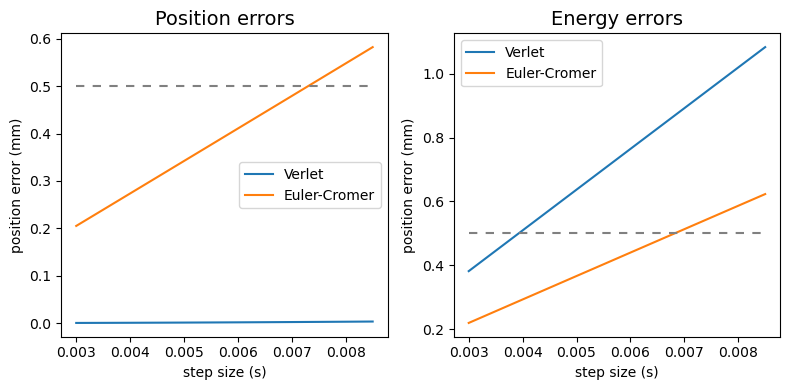

In [102]:
# Array of step sizes in appropriate range (estimated according to previous results).
hsteps = np.arange(0.003, 0.009, 0.0005)

# Creating empty arrays to append values at each hstep
mean_verlet_position_error = np.array([])
mean_cromer_position_error = np.array([])
mean_verlet_energy_error = np.array([])
mean_cromer_energy_error = np.array([])

for hstep in hsteps:
    
    # Define some time period over which we observe the system and corresponding number of steps
    T = np.arange(0, 60, hstep)
    nsteps = len(T)
    
    # Determine approximated and analytical results
    x_V, v_V = VerletMethod(b, nsteps, hstep)
    x_C, v_C = EulerCromerMethod(b, nsteps, hstep)
    x_real, v_real = Analytic(b, T, velocity=True)
    
    # Determine corresmonding errors
    verlet_position_error = np.abs(x_real.real - x_V)
    cromer_position_error = np.abs(x_real.real - x_C)
    verlet_energy_error = np.abs(Energy(x_real.real, v_real.real) - Energy(x_V, v_V))
    cromer_energy_error = np.abs(Energy(x_real.real, v_real.real) - Energy(x_C, v_C))
    
    # Append corresponding mean values
    mean_verlet_position_error = np.append(mean_verlet_position_error, np.mean(verlet_position_error))
    mean_cromer_position_error = np.append(mean_cromer_position_error, np.mean(cromer_position_error))
    mean_verlet_energy_error = np.append(mean_verlet_energy_error, np.mean(verlet_energy_error))
    mean_cromer_energy_error = np.append(mean_cromer_energy_error, np.mean(cromer_energy_error))

# plot the results

figure = plt.figure(figsize=(8, 4))
position_axes = figure.add_subplot(121)
position_axes.plot(hsteps, mean_verlet_position_error * 1000, label='Verlet')
position_axes.plot(hsteps, mean_cromer_position_error * 1000, label='Euler-Cromer')
position_axes.plot(hsteps, 0 * hsteps + 0.5, c='grey', dashes=[4, 4])
position_axes.legend()
position_axes.set_title('Position errors', fontsize=14)
position_axes.set_xlabel('step size (s)')
position_axes.set_ylabel('position error (mm)')

energy_axes = figure.add_subplot(122)
energy_axes.plot(hsteps, mean_verlet_energy_error * 1000, label='Verlet')
energy_axes.plot(hsteps, mean_cromer_energy_error * 1000, label='Euler-Cromer')
energy_axes.plot(hsteps, 0 * hsteps + 0.5, c='grey', dashes=[4, 4])
energy_axes.legend()
energy_axes.set_title('Energy errors', fontsize=14)
energy_axes.set_xlabel('step size (s)')
energy_axes.set_ylabel('position error (mm)')

plt.tight_layout()
plt.show()

The relationship between step size and mean error for both quantities and positions looks surprisingly linear on this scale. It is now even more apparent that for position, Verlet method is doing much better than Euler-Cromer, having negligible errors for given step size range. Considering energy, two methods are comparable, but Verlet method is making better predictions because of the specific design. The desired maximum error tolerance is marked as a dashed grey line of the plots, which makes it easier to estimate the maximum step size, required for each method. 

If energy is not considered, Verlet method will do enough with step size of 0.1 s according to rough calculation done at the beginning of this section. But if energy is important, then Euler-Cromer would be enough at about 0.0065 s step size and Verlet at 0.0035 s step size, which corresponds to 9230 and 17142 simulation steps to reach desired accuracy, respectively. Therefore, Euler-Cromer method needs to be chosen when energy is an important parameter of the system.

## Damping constants investigation 

So far only values of damping constant b under the critical damping were considered. However, the behaviour of the oscillator depends significantly on whether b is less than, more than or equal to the value of critical damping constant $b_{cr} = \sqrt {4km}$. All three options are considered below.

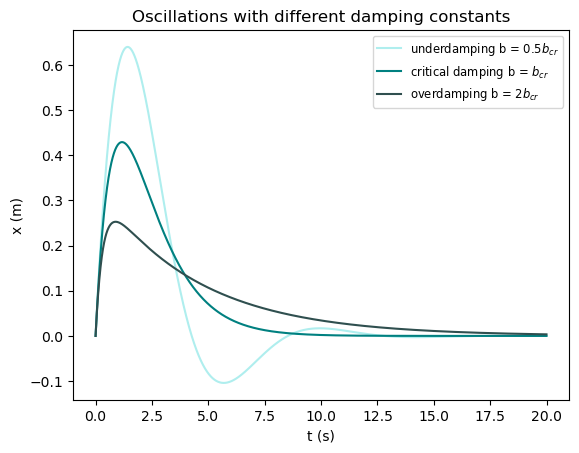

In [103]:
# redefine damping constants
b_array = np.array([0.5 * np.sqrt(4*k*m), np.sqrt(4*k*m), 2 * np.sqrt(4*k*m)])
T = 20
V0 = 1

# Arrays for plot
colours = np.array(['paleturquoise', 'teal', 'darkslategrey'])
labels = np.array(['underdamping b = $0.5b_{cr}$',
                   'critical damping b = $b_{cr}$', 
                   'overdamping b = 2$b_{cr}$'])

# plot the prediction given by the Euler-Cromer model.

for i in range(3):

    # Determine how many steps there are using the chosen number of steps
    hstep = 0.005
    nsteps = int(T/hstep)

    # call the iterative method 
    x, v = EulerCromerMethod(b_array[i], nsteps, hstep, v0=1)
    # plot the outcome by displaying the position only 
    plt.plot(np.arange(0, T, hstep), x, color=colours[i], label=labels[i])
    
    # graph formating
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.legend(fontsize='small')
    plt.title('Oscillations with different damping constants')

plt.show()

The model shows exactly what is expected from a free simple harmonic oscillator. Underdamping allows a few oscillations with the exponentially decreasing amplitude. In critical damping and overdamping no full oscillations completed. In critical damping, amplitude falls down to zero the quickest.

### Comparison with analytical solution.

In order to do that, we first need to define the analytical solution for critical damping, as the previous one will not work for this special case.

For critical damping, the system behaves as: <br>
$x(t) = (A + Bt)e^{\frac{-\gamma t}{2}}$. $A$ and $B$ are defined by initial conditions.

In [104]:
# Define new analytical solution function.

def AnalyticCritical(b, time, x0=0, v0=-1):
    """
    Alalytical model of a damped harmonic oscillator for critical damping.
    
    Parameters
    ----------
    b - damping constant (float)
    time - time of the oscillations (float array)
    x0 - initial position (float) default = 0
    v0 - initial velocity (float) default = -1
    
    Return
    ----------
    x - position for each time (float array)
    """
    
    # define constants A and B
    A = x0
    B = v0 + b*x0/(2*m)
    
    # write up the solution
    x = (A + B * time) * np.exp(-b*time/(2*m))
    
    return x

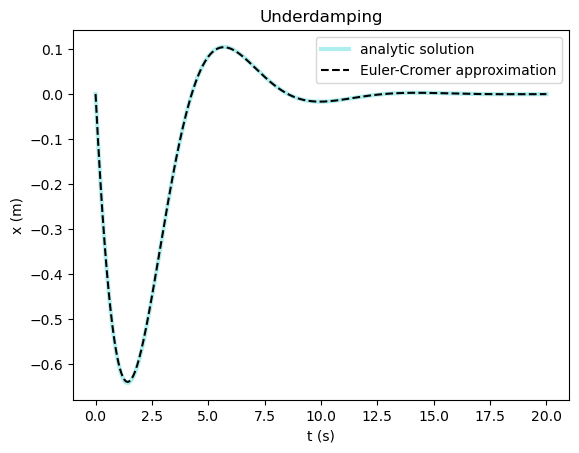

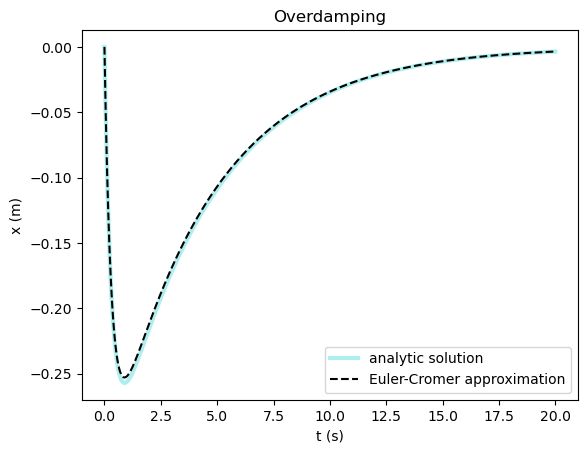

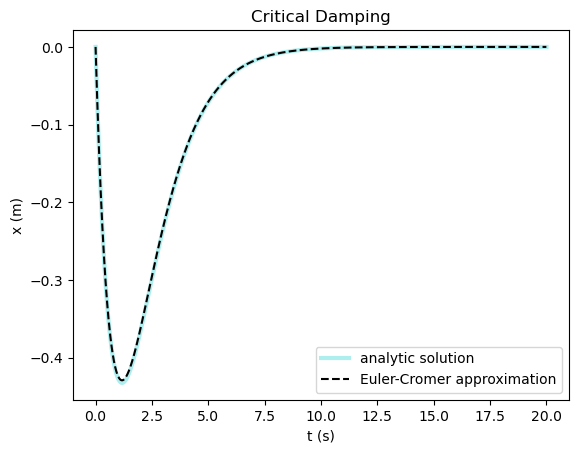

In [105]:
# plot the comparison
T = np.arange(0, 20.001, 0.005)

# for underdamping and overdamping we can use a predefined function

AnalyticCompare(0.5 * np.sqrt(4*k*m), 0.005, T, EulerCromerMethod, 
                'Euler-Cromer approximation', 'Underdamping', 'paleturquoise')
AnalyticCompare(2 * np.sqrt(4*k*m), 0.005, T, EulerCromerMethod, 
                'Euler-Cromer approximation', 'Overdamping', 'paleturquoise')

# for critical dmping, create a plot from scratch

# Plot analytic solution
plt.plot(T, AnalyticCritical(np.sqrt(4*k*m), T).real, linewidth=3, color='paleturquoise', label='analytic solution')

nsteps = int(T[-1]/0.005)

# call the iterative method 
x, v = EulerCromerMethod(np.sqrt(4*k*m), nsteps, 0.005)
# plot the outcome by displaying the position only 
plt.plot(np.arange(0, T[-1], 0.005), x, 'k--', label='Euler-Cromer approximation')

# labeling plot 
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.title('Critical Damping')
plt.legend()
plt.show()

Graphs are inverted due to the opposite initial velocity, which does not affect the success of the model.

## Forced oscillations 

### A single push 

In this section, the behaviour of the system will be investigated under an action of the force. This mainly changes the acceleration function to have a sudden added term, corresponding to force acting on the system.

In [106]:
def EulerCromerMethodPushed(b, nsteps, hstep, x0=0, v0=1):
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):
        
        # Calculate the acceleration at step i (in m/s)
        # Notice we don't make an array of these, as we usually don't need to remember them all
        # Incerting special values of acceleration
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        # introducing 4 equally spased in time pushes:
        if (i == int(nsteps/5) 
            or i == 2*int(nsteps/5)
            or i == 3*int(nsteps/5) 
            or i == 4*int(nsteps/5)):
            a = a + 50
            
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a*hstep
        x[i+1] = x[i] + v[i+1]*hstep
        
    return x, v

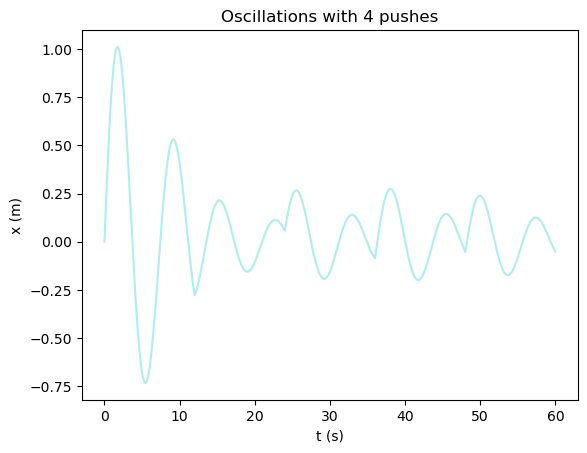

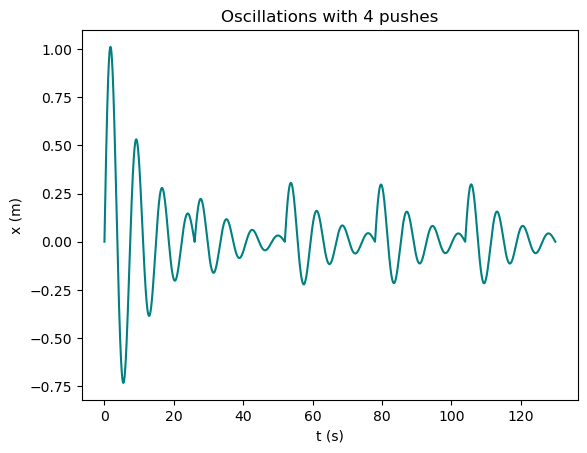

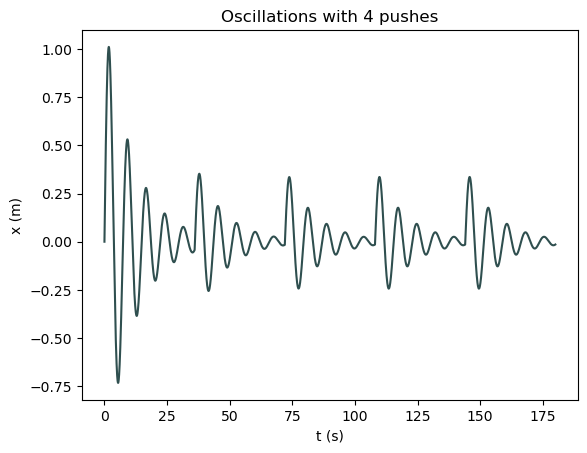

In [107]:
# redefine damping constants
b = 0.8
T_array = np.array([60, 130, 180])

# Arrays for plot
colours = np.array(['paleturquoise', 'teal', 'darkslategrey'])

# plot the prediction given by the Euler-Cromer model.

for i in range(3):
    
    T = T_array[i]

    # Determine how many steps there are using the chosen number of steps
    hstep = 0.0065
    nsteps = int(T/hstep)

    # call the iterative method 
    x, v = EulerCromerMethodPushed(b, nsteps, hstep)
    # plot the outcome by displaying the position only 
    plt.plot(np.arange(0, T - hstep, hstep), x, color=colours[i])
    
    # graph formating
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.title('Oscillations with 4 pushes')

    plt.show()

It can be seen that the system behaves as expected. A single push results an increase in velocity, which results in different patterns, depending on what was the velocity at the moment of push. With equally spaced in time pushes system tends to reach some repeating pattern over time, which leads us to the next section.

### Sinusoidal force function 

This time, a sinusoidal acceleration function is introduced instead of a single push in the form of $F = F_0sin(\omega t)$ or alternatively $a = a_0sin(\omega t)$, where $\omega$ is the frequency of driving force, which for this part is not equal to the natural frequency of the oscillator.

In [108]:
def EulerCromerMethodForced(b, nsteps, hstep, total_time, omega, x0=0, v0=1):
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    T = np.arange(0, total_time, hstep)
    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):
        
        # Calculate the acceleration at step i (in m/s)
        
        a = -(k/m)*x[i] - (b/m)*v[i] + 2 * np.sin(omega * T[i])
           
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a*hstep
        x[i+1] = x[i] + v[i+1]*hstep
        
    return x, v

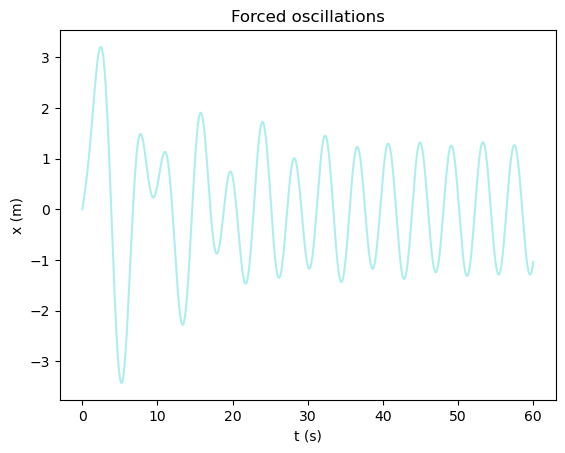

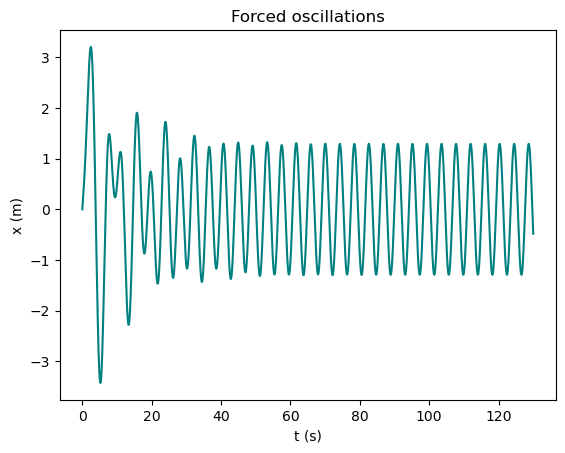

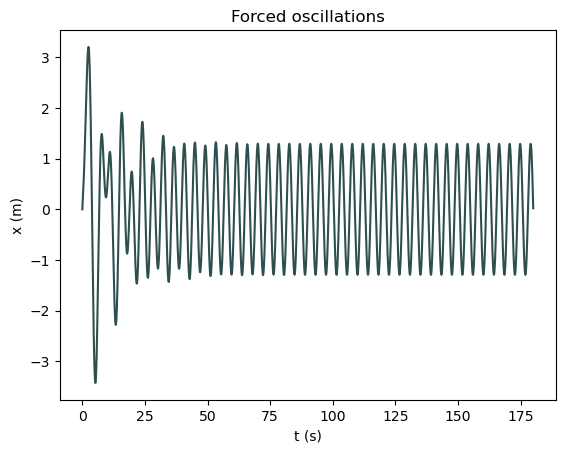

In [109]:
b = 0.8
T_array = np.array([60, 130, 180])

# plot the prediction given by the Euler-Cromer model.
for i in range(3):
    
    T = T_array[i]

    # Determine how many steps there are using the chosen number of steps
    hstep = 0.005
    nsteps = int(T/hstep)

    # call the iterative method 
    x, v = EulerCromerMethodForced(b, nsteps, hstep, T, 1.5)
    # plot the outcome by displaying the position only 
    plt.plot(np.arange(0, T, hstep), x, color=colours[i])
    
    # graph formating
    plt.xlabel("t (s)")
    plt.ylabel("x (m)")
    plt.title('Forced oscillations')

    plt.show()

It can be seen that after a transient response steady oscillations with the same frequency as driving force are left. This is predicted by solving the differential equation with a force term in it as well.

# Resonance

## Amplitude

In this section, resonance is investigated by plotting the power curve. That is, amplitude plotted against frequency for the range of driving frequencies around the natural frequency of the oscillator is $\omega_0 = \sqrt{\frac {k}{m}}$ (≈ 0.85 for given system).

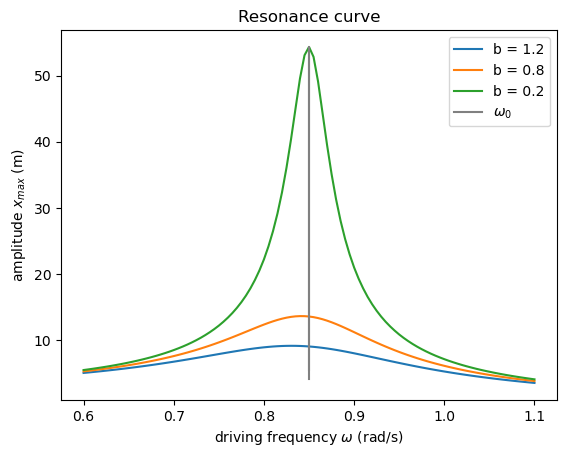

In [110]:
# Define an array of damping constants
b = np.array([1.2, 0.8, 0.2]) # kg/s

for b_i in b:

    # create an array of angular frequences (rad/s)
    ang_freq = np.arange(0.6, 1.1, 0.005)
    amplitudes = np.array([])
    T = 400
    hstep = 0.008
    nsteps = int(T/hstep)

    for omega in ang_freq:

        # run simulation
        x, v = EulerCromerMethodForced(b_i, nsteps, hstep, T, omega)

        # determine the amplitude avioding transient response
        amplitude = np.amax(x[45000:]) 

        # store it in the new array 
        amplitudes = np.append(amplitudes, amplitude)
        
        # plot the result

    plt.plot(ang_freq, amplitudes, label='b = {}'.format(b_i))

    # graph formating
    plt.xlabel("driving frequency $\omega$ (rad/s)")
    plt.ylabel("amplitude $x_{max}$ (m)")
    plt.title('Resonance curve')

plt.plot(amplitudes*0 + np.sqrt(k/m), amplitudes, color='grey', label='$\omega_0$')
plt.legend()
plt.show()

As expected, graph peaks when driving frequency matches the natural frequency of the oscillator, but the peak is misplaced slightly for higher damping constants. This is a predictable result as the maximum of resonance curve tends to the natural frequency of the system as damping goes to zero. Let us also find the error on predicted natural frequency for the least damping.

In [111]:
# calculating real natural frequency
omega_real = np.sqrt(k/m)

# picking up the prediction from the array of frequencies
omega_max = ang_freq[np.where(amplitudes == np.amax(amplitudes))]

error = np.abs(omega_real - float(omega_max))

print('error in natural frequency is {:.5f}'.format(error))

error in natural frequency is 0.00026


This is a very good result, considering the number of steps used. Therefore, it can be concluded that the model has done well in predicting forced oscillations.

## Power

We can also compare how well the approximation predicts power absorbed by the system. In theory, for the sinusoidal driving force, average power can be calculated by integrating over the full period of oscillation. 

$P = Fv = bv \times v = bv^2$

As velocity of the system varies sinusoidally,<br>
$P_{avg} = \frac{b{v_0}^2}{2}$, where $v_0(\omega)$ is the velocity amplitude, which can be calculated from the analytical solution.

Putting $v_0(\omega)$ in results,<br>
$P_{avg} = \frac{\omega^2 {F_0}^2 \gamma}{2m[({\omega_0}^2 - \omega^2)^2+\omega^2\gamma^2]}$

This solution can be compared to the calculated power average from the model.

In [112]:
# define analytic power function
def Power(omega, b):

    return ((2*m)**2 * omega**2 * (b/m))/(2*m*(((k/m) - omega**2)**2 + omega**2 * (b/m)**2))

In [113]:
# parameters of the system
ang_freq = np.arange(0.6, 1.1, 0.005)
powers = np.array([])
T = 400
hstep = 0.008
nsteps = int(T/hstep)

for omega in ang_freq:
    
    # run simulation
    x, v = EulerCromerMethodForced(0.8, nsteps, hstep, T, omega)
    
    # determine mean power and add it to the array
    power = np.mean(0.8 * v[30000:]**2)
    powers = np.append(powers, power)

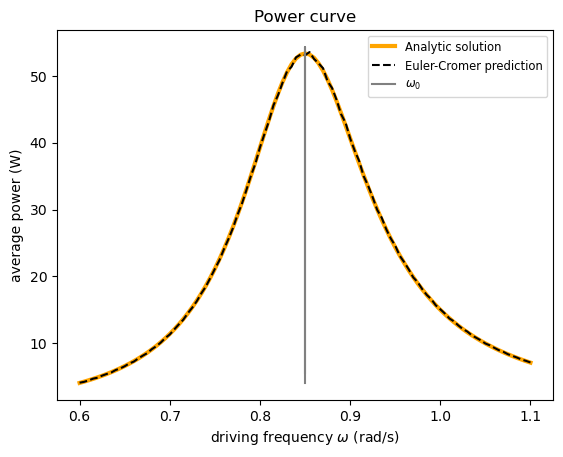

In [114]:
plt.plot(ang_freq, Power(ang_freq, 0.8), color='orange', linewidth=3, label='Analytic solution')
plt.plot(ang_freq, powers, 'k--', label='Euler-Cromer prediction')
plt.plot(amplitudes*0 + np.sqrt(k/m), amplitudes, color='grey', label='$\omega_0$')
plt.xlabel("driving frequency $\omega$ (rad/s)")
plt.ylabel("average power (W)")
plt.title('Power curve')
plt.legend(fontsize='small')
plt.show()

The integration method has done well in predicting the power, with some minor discrepancies due to the fixed averaging range. This is the case, where accuracy in energy discussed above is extremely important.